In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from numba import njit

@njit
def initialize_agents(lattice_size, num_agents, initial_infection_rate):
    num_infected = int(num_agents * initial_infection_rate)
    agents = np.zeros((num_agents, 3), dtype=np.int32)

    # Create a shuffled array of indices
    indices = np.arange(num_agents)
    np.random.shuffle(indices)

    for i in range(num_agents):
        agents[i, 0] = np.random.randint(0, lattice_size)
        agents[i, 1] = np.random.randint(0, lattice_size)
        # Infect a random 1% of the agents, based on the indices shuffled
        agents[i, 2] = 1 if i in indices[:num_infected] else 0
    
    return agents

@njit
def move_agents(agents, lattice_size, diffusion_rate):
    for i in range(agents.shape[0]):
        if np.random.random() < diffusion_rate:
            move_x = np.random.randint(-1, 2)
            move_y = np.random.randint(-1, 2)
            agents[i, 0] = (agents[i, 0] + move_x) % lattice_size
            agents[i, 1] = (agents[i, 1] + move_y) % lattice_size

@njit
def infect_agents(agents, beta, lattice_size):
    for i in range(agents.shape[0]):
        if agents[i, 2] == 1:
            for j in range(agents.shape[0]):
                if agents[j, 2] == 0 and agents[i, 0] == agents[j, 0] and agents[i, 1] == agents[j, 1]:
                    if np.random.random() < beta:
                        agents[j, 2] = 1

@njit
def update_recovery(agents, gamma):
    for i in range(agents.shape[0]):
        if agents[i, 2] == 1 and np.random.random() < gamma:
            agents[i, 2] = 2

@njit
def update_agents(agents, lattice_size, diffusion_rate, beta, gamma):
    move_agents(agents, lattice_size, diffusion_rate)
    infect_agents(agents, beta, lattice_size)
    update_recovery(agents, gamma)

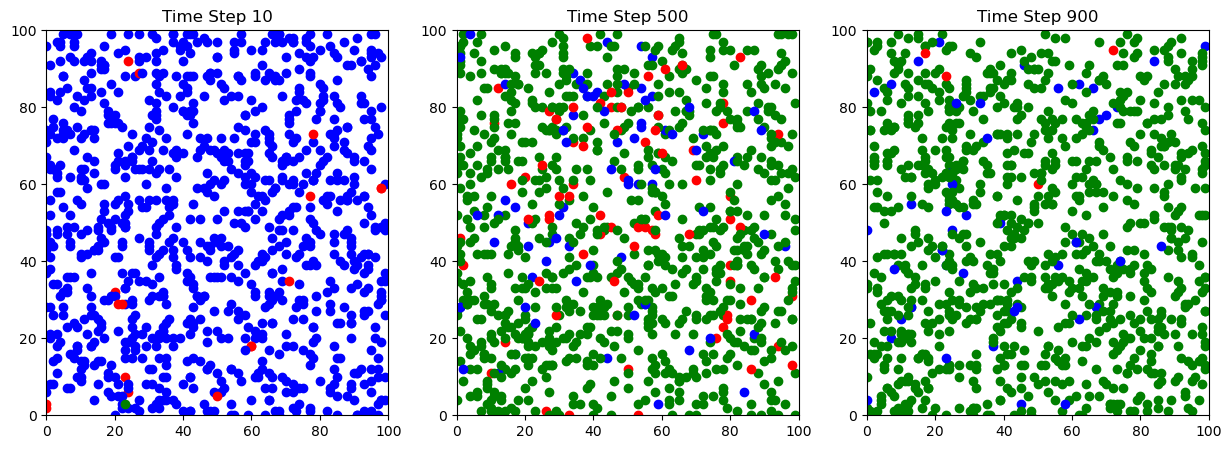

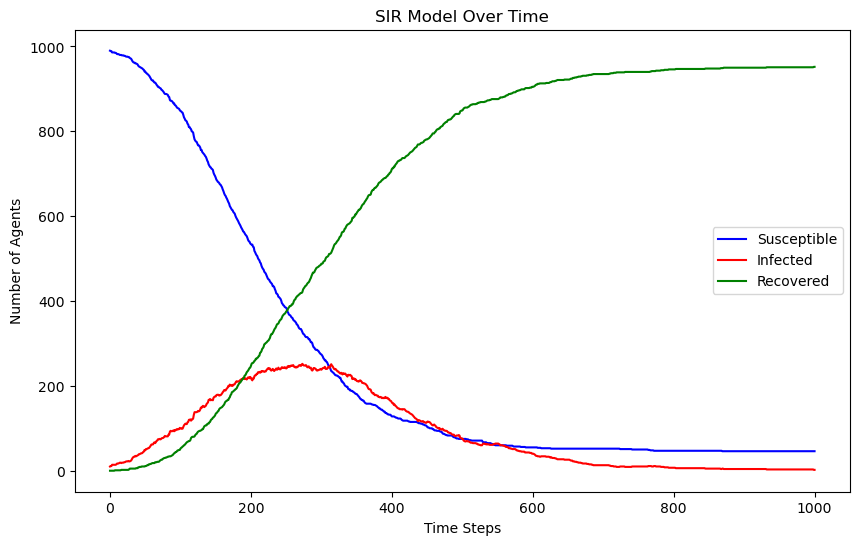

In [2]:
# Simulation params
lattice_size = 100
num_agents = 1000
beta = 0.6      # Infection rate
gamma = 0.01    # Recovery rate
diffusion_rate = 0.8  # Diffusion rate, probability to move
total_time_steps = 1000
initial_infection_rate = 0.01

# Initialize agents
agents = initialize_agents(lattice_size, num_agents, initial_infection_rate)

# Lists to track the number of S, I, R
susceptible_count = []
infected_count = []
recovered_count = []

# Simulation and Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
time_steps_to_plot = [10, 500, 900]
cmap = ListedColormap(['blue', 'red', 'green'])

for step in range(total_time_steps + 1):
    # Count S, I, R
    state_count = np.bincount(agents[:, 2], minlength=3)
    susceptible_count.append(state_count[0])
    infected_count.append(state_count[1])
    recovered_count.append(state_count[2])

    if step in time_steps_to_plot:
        ax = axes[time_steps_to_plot.index(step)]
        ax.set_title(f"Time Step {step}")
        ax.set_xlim(0, lattice_size)
        ax.set_ylim(0, lattice_size)
        for agent in agents:
            color = cmap(agent[2])
            ax.scatter(agent[0], agent[1], color=color)
    update_agents(agents, lattice_size, diffusion_rate, beta, gamma)

plt.show()

# Plot S, I, R over time
plt.figure(figsize=(10, 6))
plt.plot(susceptible_count, label='Susceptible', color='blue')
plt.plot(infected_count, label='Infected', color='red')
plt.plot(recovered_count, label='Recovered', color='green')
plt.title('SIR Model Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Number of Agents')
plt.legend()
plt.show()

In [5]:
@njit
def run_simulation(beta, gamma, total_time_steps):
    # Initialize agents
    agents = initialize_agents(lattice_size, num_agents, initial_infection_rate)

    # Lists to track the number of S, I, and R
    susceptible_count = []
    infected_count = []
    recovered_count = []

    # Run Simulation & Count SIR States
    for step in range(total_time_steps + 1):
        state_count = np.bincount(agents[:, 2], minlength=3)
        susceptible_count.append(state_count[0])
        infected_count.append(state_count[1])
        recovered_count.append(state_count[2])
        update_agents(agents, lattice_size, diffusion_rate, beta, gamma)

    return susceptible_count, infected_count, recovered_count

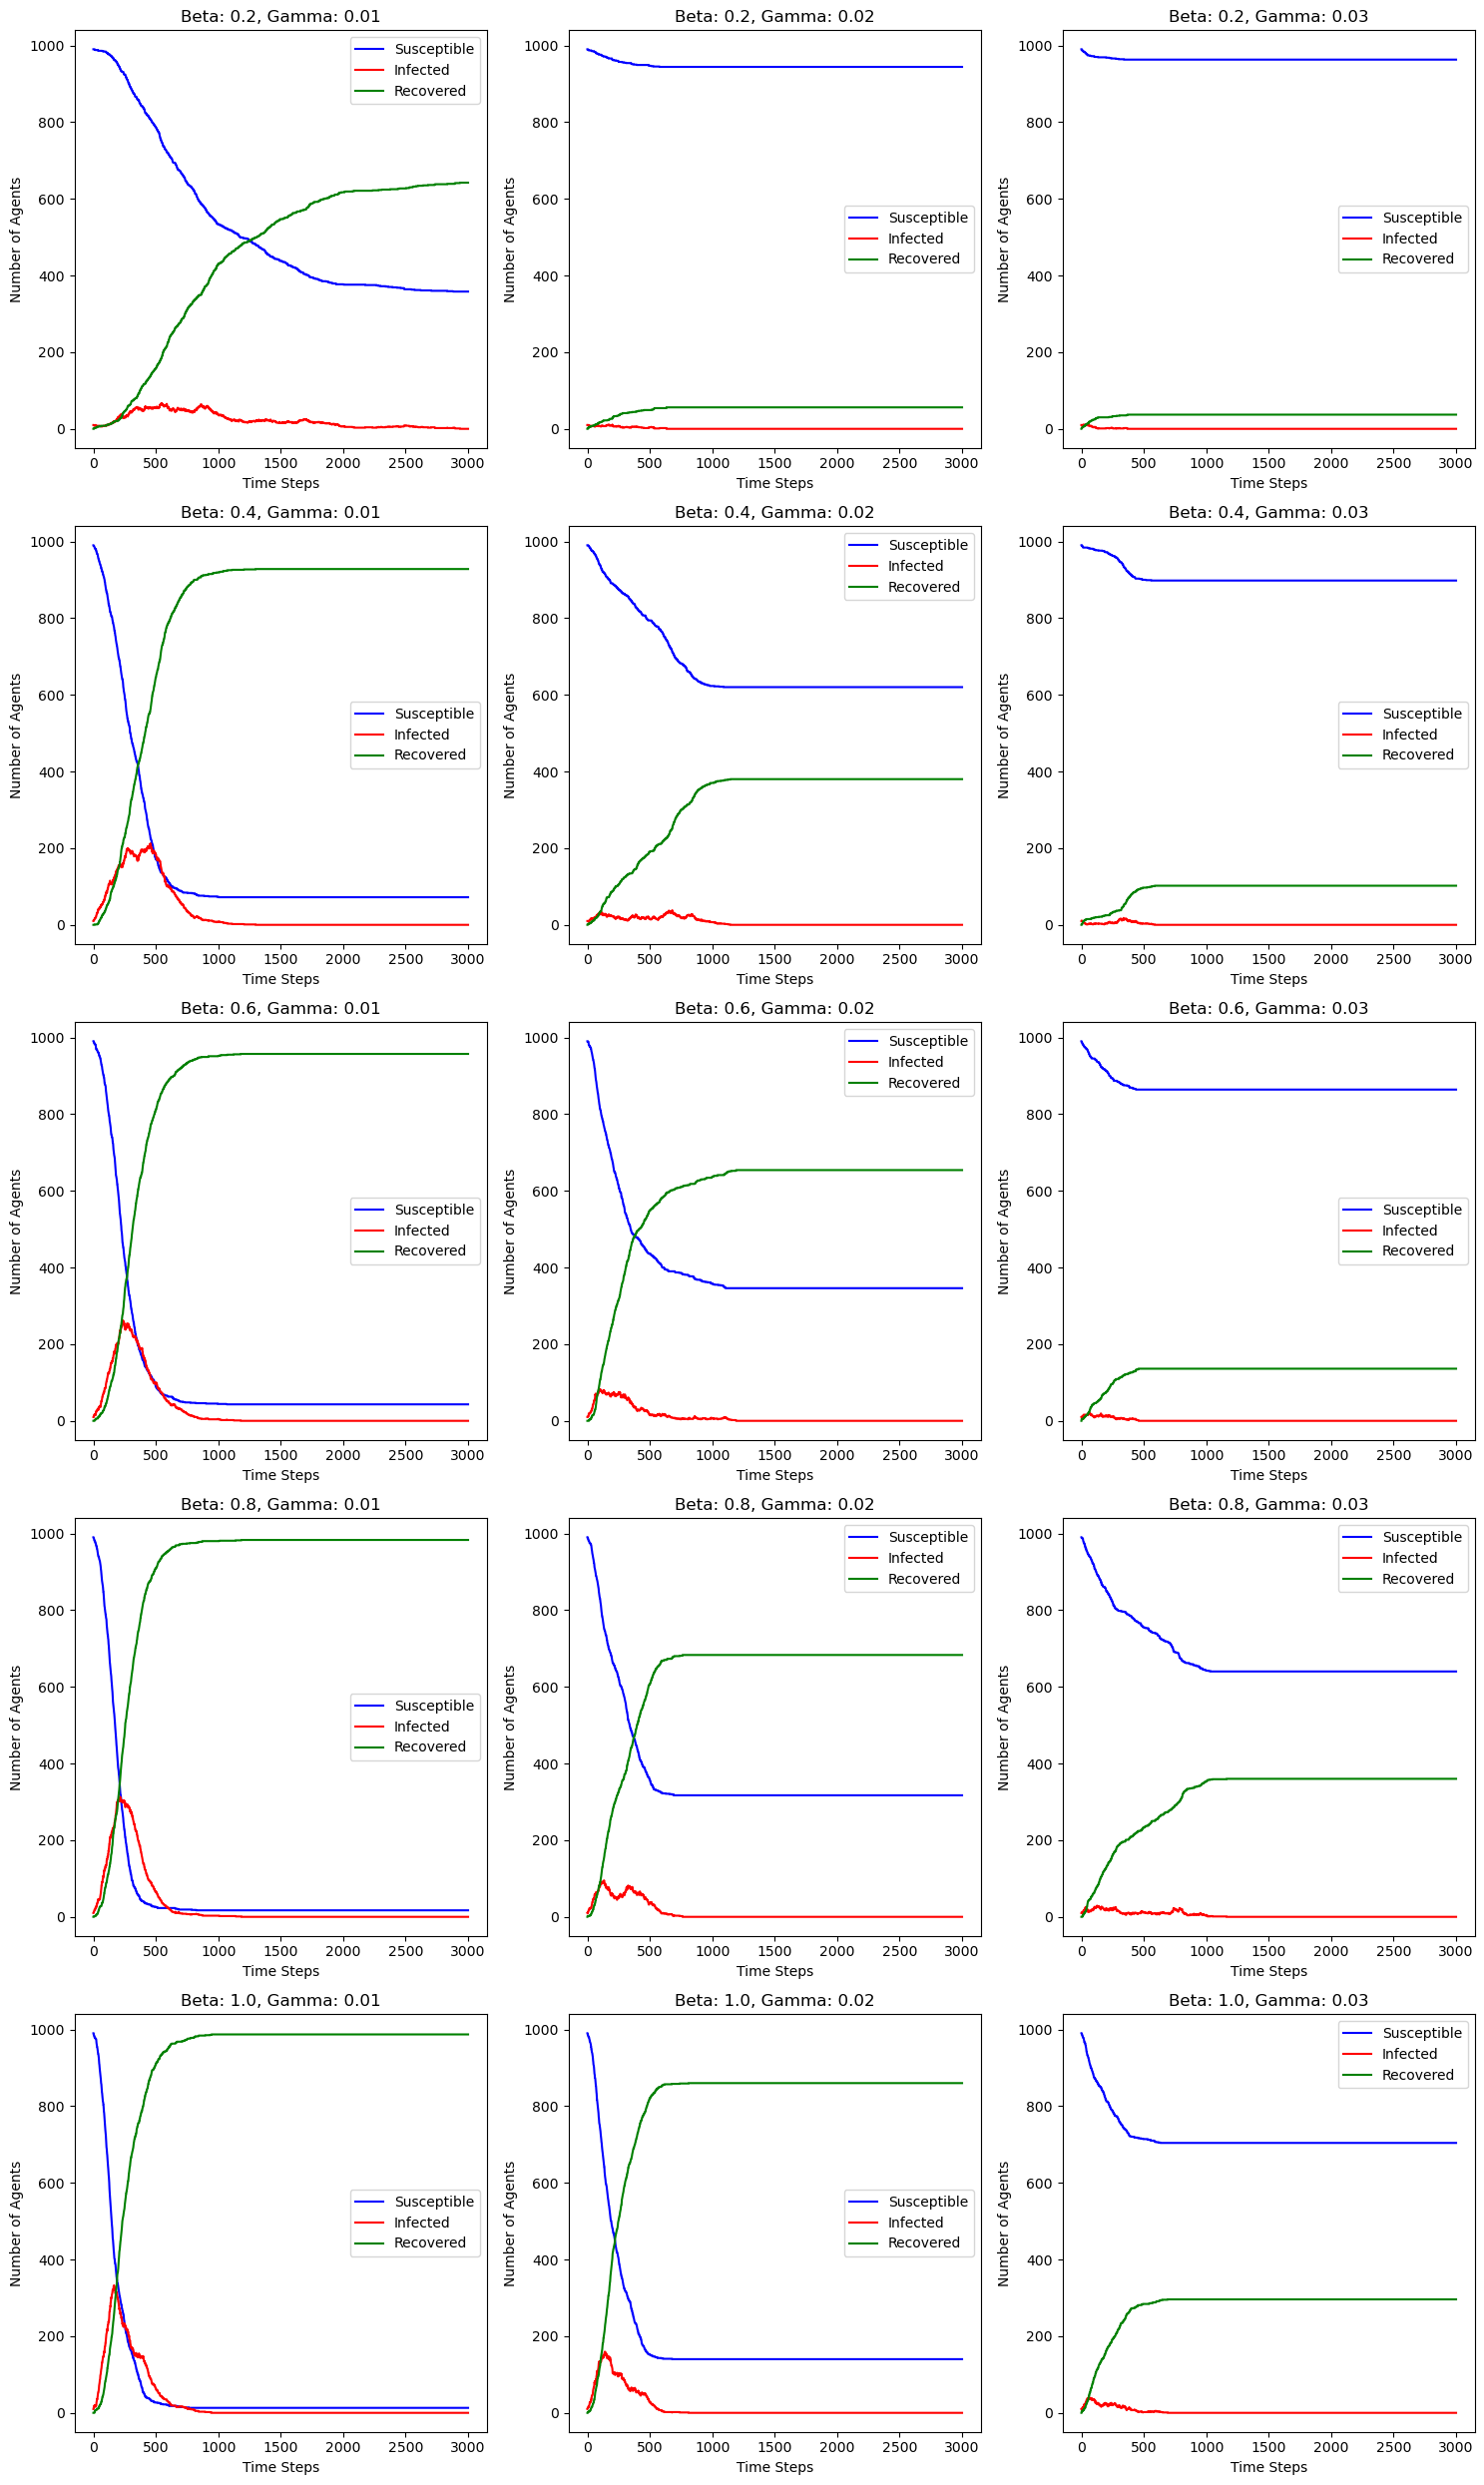

In [9]:
# Varying beta, gamma values
beta_values = [0.2, 0.4, 0.6, 0.8, 1.0]
gamma_values = [0.01, 0.02, 0.03]

plt.figure(figsize=(15, 25))

for i, beta in enumerate(beta_values):
    for j, gamma in enumerate(gamma_values):
        susceptible, infected, recovered = run_simulation(beta, gamma, total_time_steps=3000)
        
        # Plot SIR evolution beta-gamma combination
        plt.subplot(len(beta_values), len(gamma_values), i * len(gamma_values) + j + 1)
        plt.plot(susceptible, label='Susceptible', color='blue')
        plt.plot(infected, label='Infected', color='red')
        plt.plot(recovered, label='Recovered', color='green')
        plt.title(f'Beta: {beta}, Gamma: {gamma}')
        plt.xlabel('Time Steps')
        plt.ylabel('Number of Agents')
        plt.legend()

plt.tight_layout()
plt.show()

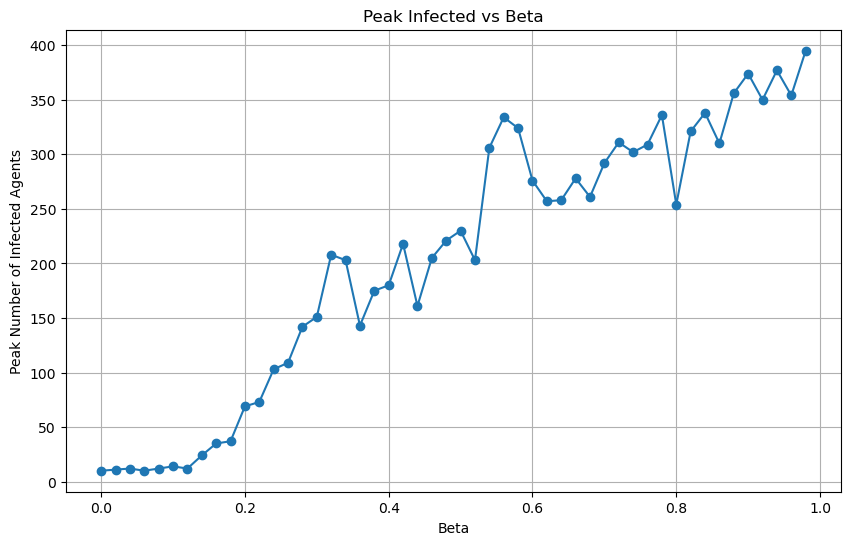

In [7]:
gamma = 0.01
beta_range = np.arange(0, 1, 0.02)

peak_infected_counts = []

for beta in beta_range:
    susceptible, infected, recovered = run_simulation(beta, gamma, total_time_steps=5000)
    peak_infected = max(infected)  # Find the peak number of infected agents
    peak_infected_counts.append(peak_infected)

plt.figure(figsize=(10, 6))
plt.plot(beta_range, peak_infected_counts, marker='o', linestyle='-')
plt.title('Peak Infected vs Beta')
plt.xlabel('Beta')
plt.ylabel('Peak Number of Infected Agents')
plt.grid(True)
plt.show()

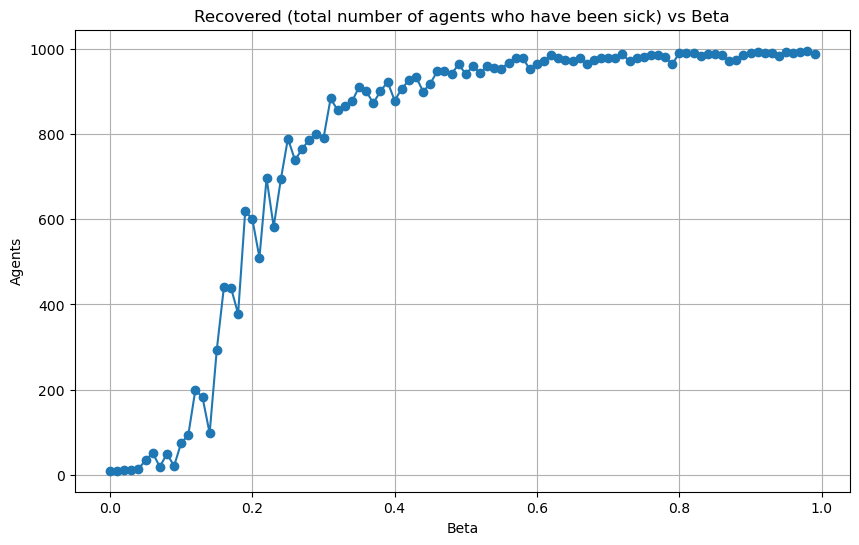

In [8]:
gamma = 0.01
beta_range = np.arange(0, 1, 0.01)

recovered_counts = []

for beta in beta_range:
    susceptible, infected, recovered = run_simulation(beta, gamma, total_time_steps=5000)
    recovered = max(recovered)
    recovered_counts.append(recovered)

plt.figure(figsize=(10, 6))
plt.plot(beta_range, recovered_counts, marker='o', linestyle='-')
plt.title('Recovered (total number of agents who have been sick) vs Beta')
plt.xlabel('Beta')
plt.ylabel('Agents')
plt.grid(True)
plt.show()